# Pneumothorax EDA to Get Started with the Competition

In [1]:
# Imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime

from glob import glob

import os
print(os.listdir("../input"))

from matplotlib import pyplot as plt
import matplotlib
import pydicom

import sys
sys.path.insert(0, '../input/siim-acr-pneumothorax-segmentation')
from mask_functions import rle2mask # import mask utilities

['siim-train-test', 'siim-acr-pneumothorax-segmentation']


## Load Data

Unfortunately, there is only a sample of competition data on Kaggle, but many thanks to [See__](https://www.kaggle.com/seesee), who created [full dataset](https://www.kaggle.com/seesee/siim-train-test) on Kaggle. I used this dataset and some code from [his kernel](https://www.kaggle.com/seesee/full-dataset).

Load the dataset:

In [2]:
# Load full training and test sets
train_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-train/*/*/*.dcm'))
test_fns = sorted(glob('../input/siim-train-test/siim/dicom-images-test/*/*/*.dcm'))

print('The training set contains {} files.'.format(len(train_fns)))
print('The test set contains {} files.'.format(len(test_fns)))

The training set contains 10712 files.
The test set contains 1377 files.


In [3]:
# load masks for training images
train_rle = pd.read_csv('../input/siim-train-test/siim/train-rle.csv')
train_rle.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


Explore the number of examples in train and test sets:

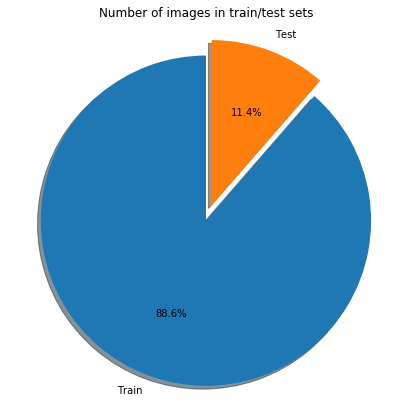

In [4]:
# visualize pie chart
labels = 'Train', 'Test'
sizes = [len(train_fns), len(test_fns)]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Number of images in train/test sets")
plt.show()

Explore the number of examples with Pneumothorax in train set:

In [5]:
without_neumothorax = train_rle[train_rle[' EncodedPixels'] == ' -1'][' EncodedPixels'].count() # note that the name of the column starts with a space 0_o
with_neumothorax = train_rle[train_rle[' EncodedPixels'] != ' -1'][' EncodedPixels'].count()

print('There are {} samples with pneumothorax in training set.'.format(with_neumothorax))
print('There are {} samples without pneumothorax in training set.'.format(without_neumothorax))

There are 3286 samples with pneumothorax in training set.
There are 8296 samples without pneumothorax in training set.


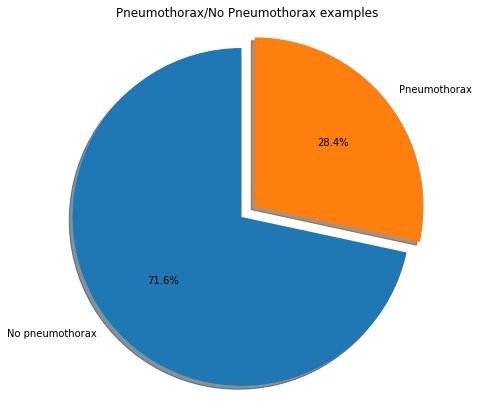

In [6]:
# visualize pie chart
labels = 'No pneumothorax', 'Pneumothorax'
sizes = [without_neumothorax, with_neumothorax]
explode = (0, 0.1)  # "explode" the 2nd slice

fig, ax = plt.subplots(figsize=(7,7))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Pneumothorax/No Pneumothorax examples")
plt.show()

We see that __the training set is imbalanced__: the majority of images don't have any Pneumothorax on them.

It seems that there are __more rows in the table, than provided images__. Let's find out how many images are lost for the training set:

In [7]:
missing_data = len(train_rle) - len(train_fns)
print('There are {} missing samples.'.format(missing_data))

There are 870 missing samples.


## Analyze Metadata

We are also provided with some metadata for each image.

The following function will help us to explore this metadata:

In [8]:
def get_metadata(file_path):
    '''
    Function get the metadata from file.
    INPUT:
        file_path - path to the file containing the image
    OUTPUT:
        age - patient's age
        sex - patient's sex
        modality - represents file type (CR = Computed Radiography) (see https://www.dicomlibrary.com/dicom/modality/)
        body_part - part of the body on image
        view_position - PA or AP (PA - view from posterior, AP - the opposite view,
            see https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
    '''
    
    dataset = pydicom.dcmread(file_path)
    
    age = dataset.PatientAge
    sex = dataset.PatientSex
    modality = dataset.Modality
    body_part = dataset.BodyPartExamined
    view_position = dataset.ViewPosition

    return age, sex, modality, body_part, view_position

Add metadata to the dataframe:

In [9]:
# copy dataframe
train_rle_meta = train_rle.copy()

# create new columns
train_rle_meta['age'] = np.nan
train_rle_meta['sex'] = np.nan
train_rle_meta['modality'] = np.nan
train_rle_meta['body_part'] = np.nan
train_rle_meta['view_position'] = np.nan

# fill columns
for fn in train_fns:
    try:
        age, sex, modality, body_part, view_position = get_metadata(fn)
        image_id = fn.split('/')[-1][:-4]

        # get index
        ind = train_rle_meta[train_rle_meta.ImageId == image_id]['age'].index[0]

        # set metadata values by index
        train_rle_meta.iloc[ind, train_rle_meta.columns.get_loc('age')] = age
        train_rle_meta.iloc[ind, train_rle_meta.columns.get_loc('sex')] = sex
        train_rle_meta.iloc[ind, train_rle_meta.columns.get_loc('modality')] = modality
        train_rle_meta.iloc[ind, train_rle_meta.columns.get_loc('body_part')] = body_part
        train_rle_meta.iloc[ind, train_rle_meta.columns.get_loc('view_position')] = view_position
    except:
        print('Index for {} not found.'.format(fn))

Index for ../input/siim-train-test/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10231.1517875222.737142/1.2.276.0.7230010.3.1.3.8323329.10231.1517875222.737141/1.2.276.0.7230010.3.1.4.8323329.10231.1517875222.737143.dcm not found.
Index for ../input/siim-train-test/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10362.1517875223.377844/1.2.276.0.7230010.3.1.3.8323329.10362.1517875223.377843/1.2.276.0.7230010.3.1.4.8323329.10362.1517875223.377845.dcm not found.
Index for ../input/siim-train-test/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10407.1517875223.567350/1.2.276.0.7230010.3.1.3.8323329.10407.1517875223.567349/1.2.276.0.7230010.3.1.4.8323329.10407.1517875223.567351.dcm not found.
Index for ../input/siim-train-test/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10599.1517875224.488726/1.2.276.0.7230010.3.1.3.8323329.10599.1517875224.488725/1.2.276.0.7230010.3.1.4.8323329.10599.1517875224.488727.dcm not found.
Index for ../input/siim-train-te

It [was also discovered](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/97119#latest-562337) that filenames of the images contain timestamps. Let's add them to the table and try to analyze:

In [10]:
# create new columns
train_rle_meta['timestamp'] = ''
train_rle_meta['year'] = np.nan
train_rle_meta['month'] = np.nan
train_rle_meta['day'] = np.nan

# iterate through dataframe
for index, row in train_rle_meta.iterrows():
    image_id = row.ImageId
    
    # get unix timestamp string from image id
    unix_ts = int(image_id.split('.')[-2])
    
    # get timestamp
    ts = datetime.fromtimestamp(unix_ts)
    
    # add timestamp to dataframe
    train_rle_meta.iloc[index, train_rle_meta.columns.get_loc('timestamp')] = ts.strftime('%Y-%m-%d %H:%M:%S')
    train_rle_meta.iloc[index, train_rle_meta.columns.get_loc('year')] = ts.year
    train_rle_meta.iloc[index, train_rle_meta.columns.get_loc('month')] = ts.month
    train_rle_meta.iloc[index, train_rle_meta.columns.get_loc('day')] = ts.day

In [11]:
train_rle_meta.head()

,ImageId,EncodedPixels,age,sex,modality,body_part,view_position,timestamp,year,month,day
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1,51,F,CR,CHEST,PA,2018-02-05 23:59:48,2018.0,2.0,5.0
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1,17,F,CR,CHEST,AP,2018-02-06 00:00:39,2018.0,2.0,6.0
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...,69,F,CR,CHEST,PA,2018-02-05 23:59:45,2018.0,2.0,5.0
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...,57,F,CR,CHEST,AP,2018-02-05 23:59:21,2018.0,2.0,5.0
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...,NaN,NaN,NaN,NaN,NaN,2018-02-05 23:59:21,2018.0,2.0,5.0


In [12]:
# save csv for later
train_rle_meta.to_csv('train_data_meta.csv')

Visualize statistics for metadata:

In [13]:
# remove nan
train_rle_meta_cleaned = train_rle_meta.dropna()

Plot histogram for age column:

In [14]:
# convert age to numeric
train_rle_meta_cleaned["age"] = pd.to_numeric(train_rle_meta_cleaned["age"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


It seems that we have some outliers for age values. Let's look at rows, where age is greater than 100:

In [15]:
train_rle_meta_cleaned[train_rle_meta_cleaned['age'] > 100]

,ImageId,EncodedPixels,age,sex,modality,body_part,view_position,timestamp,year,month,day
8112,1.2.276.0.7230010.3.1.4.8323329.4830.151787518...,-1,148,M,CR,CHEST,PA,2018-02-05 23:59:45,2018.0,2.0,5.0
10529,1.2.276.0.7230010.3.1.4.8323329.11106.15178752...,-1,413,F,CR,CHEST,AP,2018-02-06 00:00:31,2018.0,2.0,6.0


Surprisingly, there are very old people in the dataset. I will consider these as outliers.

That's why I will plot histograms for age values less than 100:

Text(0.5, 1.0, 'Age with Pneumothorax')

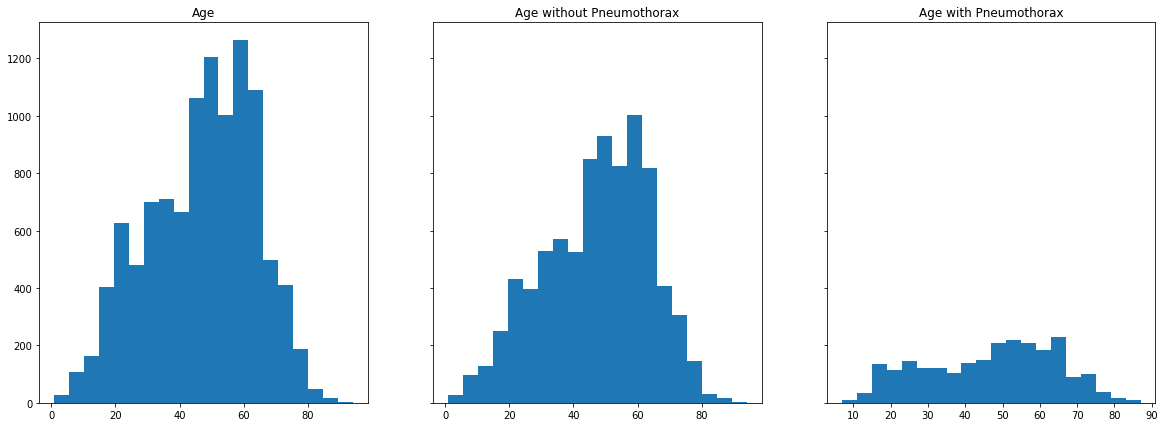

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(20,7), sharey=True,)

axs[0].hist(train_rle_meta_cleaned[train_rle_meta_cleaned['age'] < 100]['age'].values, bins=20)
axs[0].set_title('Age')

axs[1].hist(train_rle_meta_cleaned[(train_rle_meta_cleaned['age'] < 100) & (train_rle_meta_cleaned[' EncodedPixels'] == ' -1')]['age'].values, bins=20)
axs[1].set_title('Age without Pneumothorax')

axs[2].hist(train_rle_meta_cleaned[(train_rle_meta_cleaned['age'] < 100) & (train_rle_meta_cleaned[' EncodedPixels'] != ' -1')]['age'].values, bins=20)
axs[2].set_title('Age with Pneumothorax')

It seems that Pneumothorax doesn't really depend on one's age.

Plot bar charts for other columns:

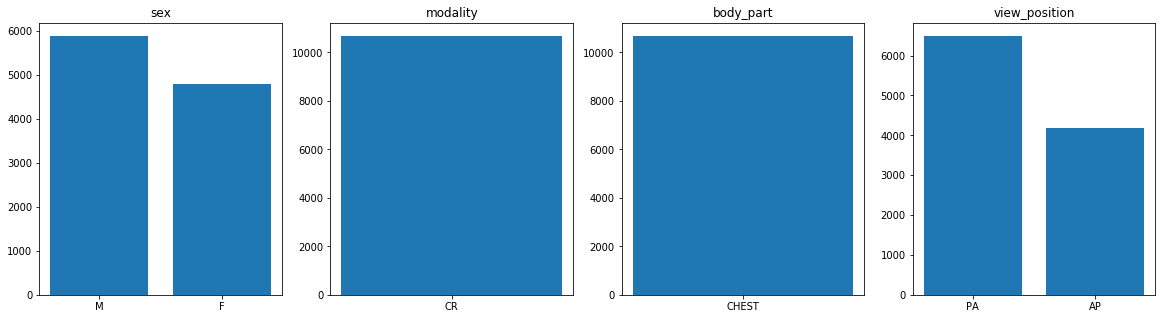

In [17]:
columns = ['sex', 'modality', 'body_part', 'view_position']

fig, axs = plt.subplots(1, 4, figsize=(20,5))

for i in range(4):
    column = columns[i]
    
    x_pos = np.arange(0, len(train_rle_meta_cleaned[column].unique()))
    
    axs[i].bar(x_pos, train_rle_meta_cleaned[column].value_counts().values, align='center')
    
    tick_labels = []
    for label in train_rle_meta_cleaned[column].value_counts().index.values.tolist():
        tick_labels.append(label)
        
    axs[i].set_xticks(range(len(tick_labels)))
    axs[i].set_xticklabels(tick_labels)

    axs[i].set_title(column)

Modality and body part features are not informative. This is quite obvious, that we have all the images of the same type.

Let's take a look at dates extracted from filenames:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda9c1de080>]],
      dtype=object)

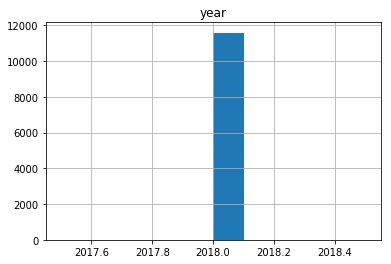

In [18]:
train_rle_meta.hist(column = 'year')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda9c1014a8>]],
      dtype=object)

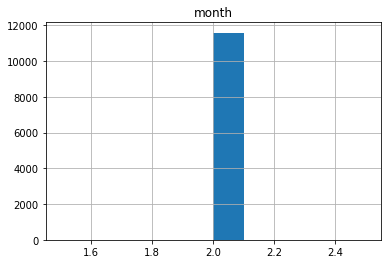

In [19]:
train_rle_meta.hist(column = 'month')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda9c08c048>]],
      dtype=object)

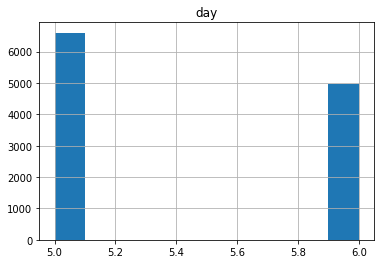

In [20]:
train_rle_meta.hist(column = 'day')

From the plots above we see that all images are marked with 2018-02-05 or 2018-02-06. So datetimes from filenames are not informative at all.

## Plot Sample Images

Many thanks to [this kernel](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data) for showing how to work with the images.

At first let's plot some random images at first:

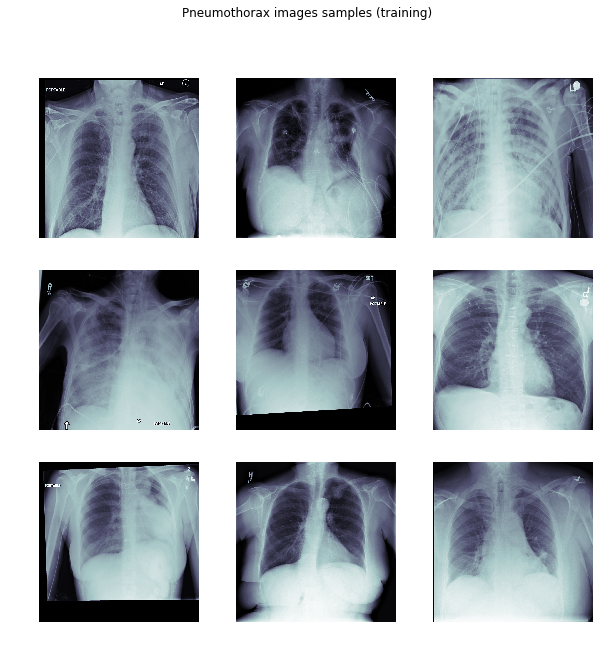

In [21]:
# Plot 9 random images from training dataset
fig, axs = plt.subplots(3, 3, figsize=(10,10))
    
for im in range(9):
    i = im // 3
    j = im % 3

    # choose random images from train set
    fn = np.random.choice(train_fns)
    img = pydicom.read_file(fn).pixel_array

    #plot the data
    axs[i,j].imshow(img, cmap='bone')
    axs[i,j].axis('off')
        
# set suptitle
plt.suptitle('Pneumothorax images samples (training)')
plt.show()

Let's visualize some images of patients without Pneumothorax and related metadata:

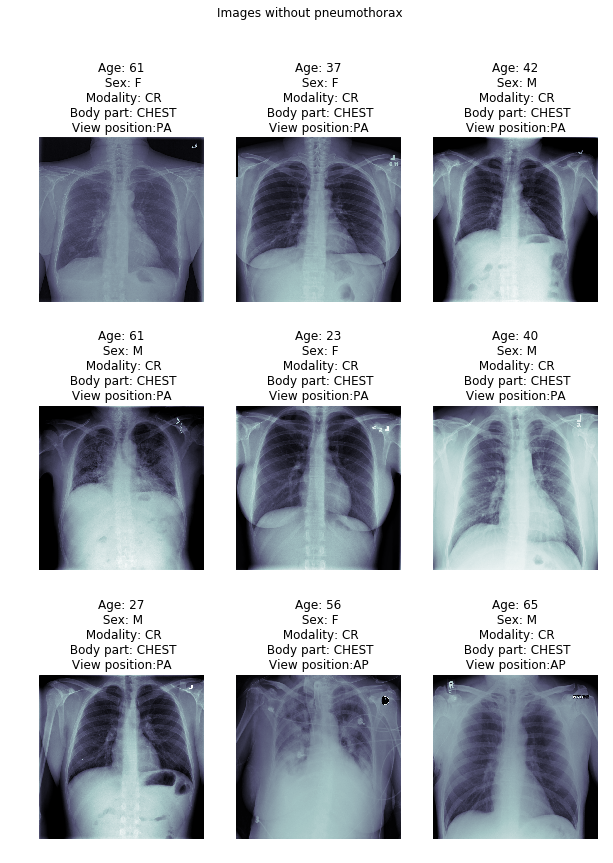

In [22]:
# visualize random images without Pneumothorax
# plot 9 random images from training dataset
fig, axs = plt.subplots(3, 3, figsize=(10,14))
im = 0

while im < 9:
    i = im // 3
    j = im % 3

    # get random images from training set
    fn = np.random.choice(train_fns)
    img = pydicom.read_file(fn).pixel_array
    
    # get id of the image
    image_id = fn.split('/')[-1][:-4]
    
    # find mask
    # if mask = -1 (no Pneumothorax) then display image and increase counter
    # otherwise look for another image
    mask = train_rle[train_rle.ImageId == image_id].iloc[0].values[1]
    if mask == ' -1':
        im += 1
        meta = get_metadata(fn)
        axs[i,j].imshow(img, cmap='bone') #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title('Age: {age}\n Sex: {sex}\n Modality: {modality}\n Body part: {body_part}\n View position:{view} '.format(age = meta[0],
                                                                                                                                   sex = meta[1],
                                                                                                                                   modality = meta[2],
                                                                                                                                   body_part = meta[3],
                                                                                                                                   view = meta[4]))
        
# set suptitle
plt.suptitle('Images without pneumothorax')
plt.show()

It seems that we can __easily distinguish male from female adults__ looking on these images.

Now it is time to visualize images, which contain Pneumothorax. I will plot both the original image and the image with mask right next to it. I will also add metadata to the plot.

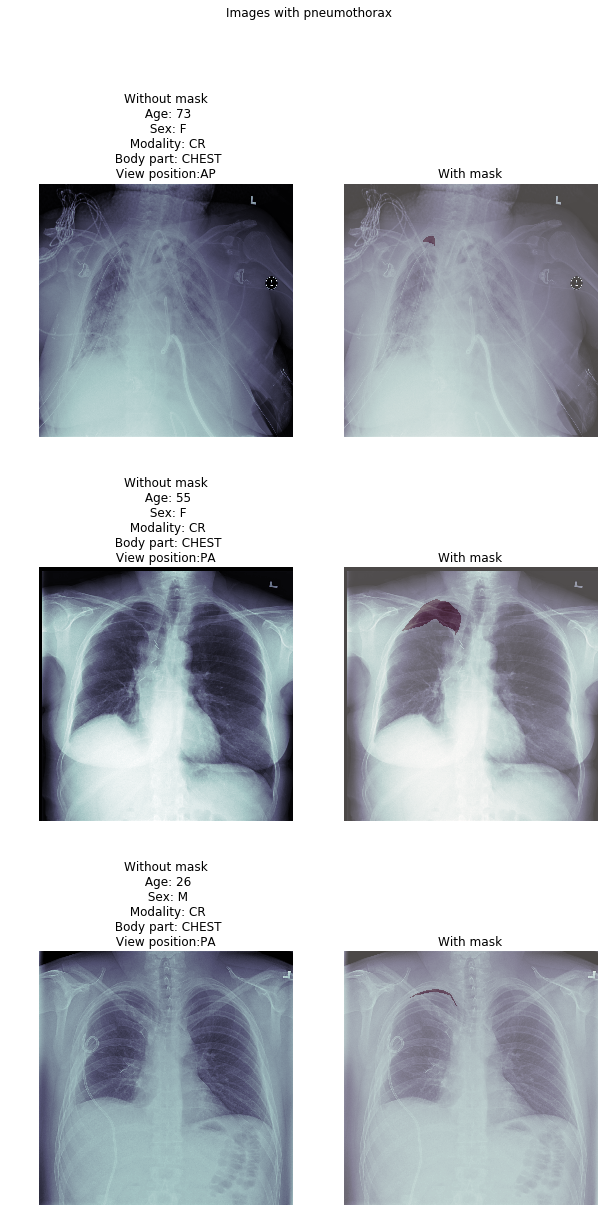

In [23]:
#visualize images with pneumothorax and masks

# plot 9 random images from training dataset
fig, axs = plt.subplots(3, 2, figsize=(10,20))
im = 0

while im < 3:
    i = im

    # get random images from training set
    fn = np.random.choice(train_fns)
    img = pydicom.read_file(fn).pixel_array
    
    # get id of the image
    image_id = fn.split('/')[-1][:-4]
    
    # find mask
    # if mask is not -1 (no Pneumothorax) then display image and increase counter
    # otherwise look for another image
    mask = train_rle[train_rle.ImageId == image_id].iloc[0].values[1]
    if mask != ' -1':
        im += 1
        
        #plot the original data
        axs[i,0].imshow(img, cmap='bone') 
        axs[i,0].axis('off')
        meta = get_metadata(fn)
        # add metadata
        axs[i,0].set_title('Without mask\n Age: {age}\n Sex: {sex}\n Modality: {modality}\n Body part: {body_part}\n View position:{view} '.format(age = meta[0],
                                                                                                                                   sex = meta[1],
                                                                                                                                   modality = meta[2],
                                                                                                                                   body_part = meta[3],
                                                                                                                                   view = meta[4]))
        
        #plot data and add the mask
        axs[i,1].imshow(img, cmap='bone')
        axs[i,1].axis('off')  
        rle_mask = rle2mask(mask, 1024, 1024).T
        axs[i,1].imshow(rle_mask, alpha=0.3, cmap="Reds")    
        axs[i,1].set_title('With mask')
        
# set suptitle
plt.suptitle('Images with pneumothorax')
plt.show()

It seems that it is __very hard to find the Pneumothorax__ on the image for an untrained person like me. Raw images certainly require soma data augmentation to make it possible to see Pneumothorax.

There is a [tutorial](https://www.radiologymasterclass.co.uk/gallery/chest/pneumothorax/pneumothorax_j#top_1st_img) on how to distinguish pneumothorax on x-ray images. It may help to analyze pneumothorax images.

## Credits
1. [Full dataset](https://www.kaggle.com/seesee/siim-train-test) and sample code from [his kernel](https://www.kaggle.com/seesee/full-dataset) by [See__](https://www.kaggle.com/seesee).
2. Thanks to [Intro - chest xray, DICOM, viz, U-nets - full data](https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data) kernel for showing how to read the data and masks.